<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/rag-system-notebooks/02_rag_system_with_gemma_and_mongodb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Step-1: Setup

**Reference**:

https://www.mongodb.com/developer/products/atlas/gemma-mongodb-huggingface-rag/

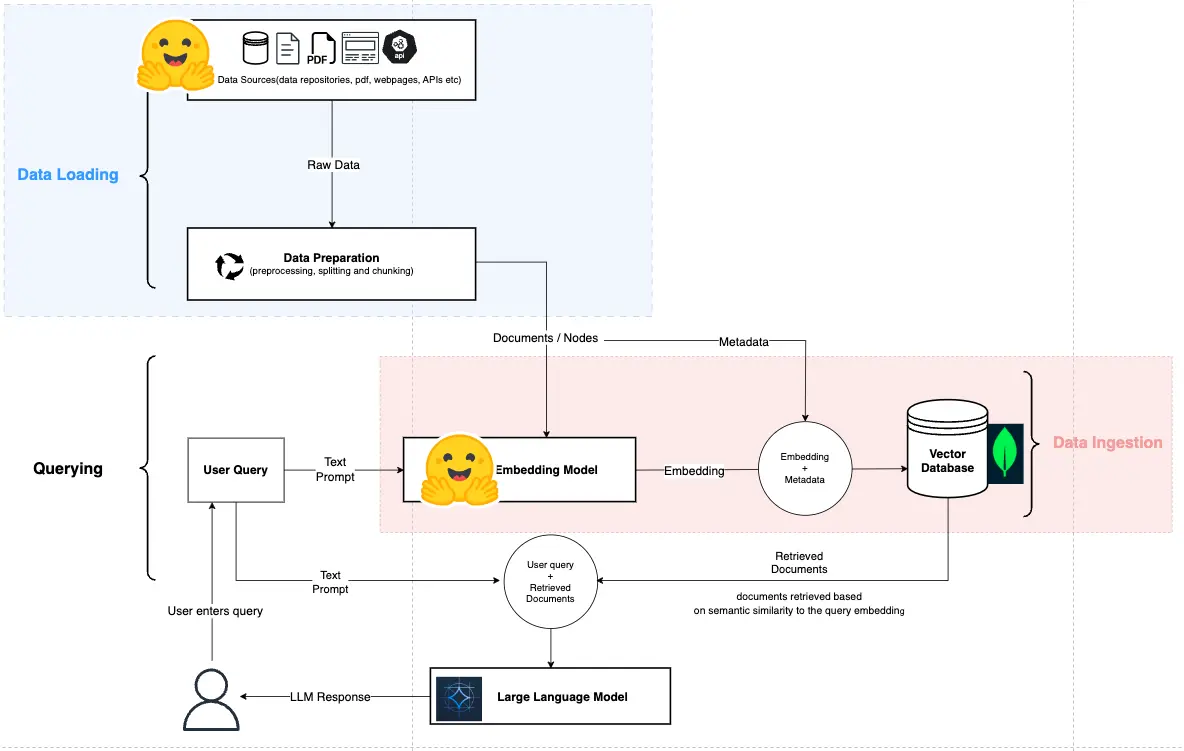

In [ ]:
!pip install datasets pandas pymongo sentence_transformers
!pip install -U transformers
# Install below if using GPU
# !pip install accelerate

In [2]:
import pandas as pd
import pymongo

from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
from datasets import load_dataset

from google.colab import userdata

##Step-2: Dataset

In [ ]:
# https://huggingface.co/datasets/AIatMongoDB/embedded_movies
# Load Dataset
dataset = load_dataset("AIatMongoDB/embedded_movies")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['languages', 'awards', 'countries', 'poster', 'writers', 'cast', 'num_mflix_comments', 'title', 'type', 'fullplot', 'rated', 'metacritic', 'directors', 'runtime', 'plot_embedding', 'imdb', 'plot', 'genres'],
        num_rows: 1500
    })
})

In [5]:
# Convert the dataset to a pandas DataFrame
dataset_df = pd.DataFrame(dataset["train"])

In [6]:
# Remove data point where plot column is missing
dataset_df = dataset_df.dropna(subset="fullplot")
print("\nNumber of missing values in each column after removal:")
print(dataset_df.isnull().sum())

# Remove the plot_embedding from each data point in the dataset as we are going
# to create new embeddings with an open-source embedding model from Hugging Face: gte-large
dataset_df = dataset_df.drop(columns=["plot_embedding"])


Number of missing values in each column after removal:
languages               1
awards                  0
countries               0
poster                 78
writers                13
cast                    1
num_mflix_comments      0
title                   0
type                    0
fullplot                0
rated                 279
metacritic            893
directors              12
runtime                14
plot_embedding          1
imdb                    0
plot                    0
genres                  0
dtype: int64


##Step-3: Generating embeddings

In [ ]:
# https://huggingface.co/thenlper/gte-large
embedding_model = SentenceTransformer("thenlper/gte-large")

def get_embedding(text: str) -> list[float]:
  if not text.strip():
    print("Attempted to get embedding for empty text.")
    return []
  embedding = embedding_model.encode(text)
  return embedding.tolist()

In [ ]:
dataset_df["embedding"] = dataset_df["fullplot"].apply(get_embedding)
dataset_df.sample()

##Step-4: MongoDB setup

In [53]:
def get_mongo_client(mongo_uri):
  """Establish connection to the MongoDB."""
  try:
    client = pymongo.MongoClient(mongo_uri)
    print("Connection to MongoDB successful")
    return client
  except pymongo.errors.ConnectionFailure as e:
    print(f"Connection failed: {e}")
    return None

In [54]:
mongo_uri = userdata.get("MONGO_URI")
if not mongo_uri:
  print("MONGO_URI not set in environment variables")

mongo_client = get_mongo_client(mongo_uri)

Connection to MongoDB successful


In [55]:
# Ingest data into MongoDB
db = mongo_client["movies"]
collection = db["movie_collection_v1"]

In [56]:
# Delete any existing records in the collection
collection.delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff0000000000000019'), 'opTime': {'ts': Timestamp(1709879305, 9), 't': 25}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1709879305, 9), 'signature': {'hash': b'@\xc5\xf2\xa3\x9b\xb4\xd7\xac<{\x91q\xc4\x9a\xbd\x89n@\xc1\xf8', 'keyId': 7319479005235642374}}, 'operationTime': Timestamp(1709879305, 9)}, acknowledged=True)

In [ ]:
# Ingesting data into a MongoDB collection
documents = dataset_df.to_dict("records") # converting the DataFrame into dictionary
collection.insert_many(documents)
print("Data ingestion into MongoDB completed")

##Step-5: Vector search index

In [ ]:
def vector_search(user_query, collection):
  """
  Perform a vector search in the MongoDB collection based on the user query.

  Args:
  user_query (str): The user's query string.
  collection (MongoCollection): The MongoDB collection to search.

  Returns:
  list: A list of matching documents.
  """
  # Generate embedding for the user query
  query_embedding = get_embedding(user_query)
  if user_query is None:
    return "Invalid query or embedding generation failed."

  # Define the vector search pipeline
  pipeline = [
      {
          "$vectorSearch": {
              "index": "vector_index",
              "queryVector": query_embedding,
              "path": "embedding",
              "numCandidates": 150, # Number of candidate matches to consider
              "limit": 4            # Return top 4 matches
          }
      },
      {
          "$project": {
              "_id": 0,       # Exclude the _id field
              "fullplot": 1,  # Include the plot field
              "title": 1,     # Include the title field
              "genres": 1,    # Include the genres field
              "score": {"$meta": "vectorSearchScore"}  # Include the search score
          }
      }
  ]

  # Execute the search
  results = collection.aggregate(pipeline)
  return list(results)

##Step-6: Query retrieval

##Step-7: LLM response